In [40]:
# @Time    : 14/9/23
# @Author  : Xu Si
# @Affiliation  : University of Science and Technolog of China
# @Email   : xusi@mail.ustc.edu.cn
# @File    : Demo_zeroshot_pred.ipynb

# SeisCLIP

#### This is a simple demo for extracting waveforms feature using SeisCLIP

## 1. import lib 

#### <blockquote> 1.This code is based on pytorch. Therefore, this tutorial need torch,numpy,matplotlib,scipy, sklearn and timm==0.4.5 (for model)... </blockquote><blockquote> 2.For running this code, I recommond your install corresponding lib with our requirement file. </blockquote><blockquote> 3.In addition, this code is a cpu version code. It is easy to run it on personal laptop. </blockquote>

In [1]:
import numpy as np
import scipy.io as sio
from scipy.signal import stft

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
# import the model
from model.model_seismic_clip import *

/Users/xusi/anaconda3/envs/pyg2.0/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


## 2.import model 

#### <blockquote> We provided two kind of pretrained model. Here, we use 50*120 size model. 

In [3]:
# How to load the model from param
def load_model(model_name,model,device_type='cpu'):
    if device_type == 'cpu':
        param = torch.load(model_name,map_location=torch.device('cpu'))
    if device_type == 'gpu': 
        param = torch.load(model_name)
    model.load_state_dict(param)
    return model

In [5]:
# The key for how to load SeisCLIP decoder.
# this model is pretrained by stead 
device = torch.device("cpu")
freeze_model = AUDIO_CLIP(
embed_dim = 384, text_input = 8,text_width = 512,text_layers=2,spec_model_size = 'small224',device_name = device).to(device)
# you must put the pretrained model in this file
model_name = './pretrained_models/pretrain_model_50_120.pt'
freeze_model = load_model(model_name,freeze_model)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=44


## 3.Load and plot data

#### <blockquote> To test our model, we provide a simple demo about cluster different signal types. We provide a data containing three types of signal: train, stone falling and people jump. Our model was pre-trained on Stead data, with a sampling rate of 100 Hz. However, the provided .mat data has a much higher sampling rate (500 Hz), so this is merely a simple test. (Thanks to Professor Xiaokai Wang from Xi'an Jiaotong University for providing the data).

In [7]:
# load data
train_jump_array = sio.loadmat("./data/train_jump.mat")
stone_array = sio.loadmat("./data/stone.mat")


In [8]:
# the shape of data is [400000,2,3], two station with three channel, 800s and 500 Hz.
train_jump_data = train_jump_array['jump_703seconds'] 
stone_data = stone_array['stone_596_598seconds']
x = np.arange(0,800,0.002)
print(x.shape)
print(train_jump_data.shape)
print(stone_data.shape)

(400000,)
(400000, 2, 3)
(400000, 2, 3)


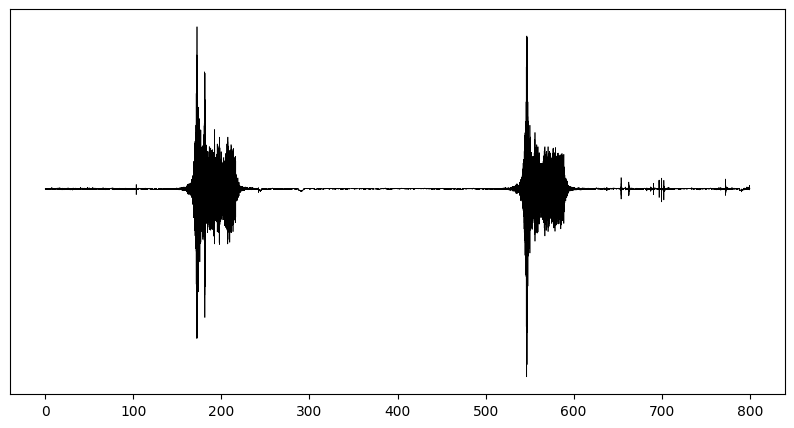

In [11]:
# The waveforms around 200 seconds and around 550 seconds are signals from a train, while the waveform signal around 703 seconds is generated by a person's movements.
plt.figure(figsize=(10,5),dpi=100)
plt.plot(x,train_jump_data[:,0,1],c='black',linewidth = 0.5)
# plt.axvline(703,c='r',linestyle='--')
plt.yticks([])
plt.show()

#### <blockquote> Since our model is spectrum-based fundation model, it need to transfer waveform to specturm. We firstly make a normlization on raw waveform and then tranfer it to spectrum using stft. </blockquote><blockquote> Notice: This data has the differet sampling frequency with the data used in our paper. People can use SeisCLIP to extract features from data spectra at any sampling rate, as long as the input frequency size remains at 50x120 or 50x600. However, this may introduce certain potential risks.

In [27]:
# define norm and spectrum function
def cal_norm_spectrogram(x,window_length,nfft,sample_rate):
    spec = np.zeros([x.shape[0],3,int(x.shape[-1]/window_length * 2),int(nfft/2)])
    for n in range(x.shape[0]):
        for i in range(3):
            _, _, spectrogram = stft(x[n,i,:], fs=sample_rate, window='hann', nperseg=window_length, noverlap=int(window_length/2), nfft=nfft,boundary='zeros')
            spectrogram = spectrogram[1:,1:]
            spec[n,i,:] = np.abs(spectrogram).transpose(1,0)
    return spec
def norm(x):
    data = x.copy()
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            data[:,i,j] = (data[:,i,j] - data[:,i,j].mean())/data[:,i,j].std()
    return data

# define a function for select spectrum
def select_part_spec(t1,t2,data,dt=500,window_length = 8, nfft = 100, sample_rate=500):
#t1 and t2 is the start and end time, dt is sampling rate, each data has two stations? Here we set 1 sample with 1 minute. 
    select_data = np.zeros([500,2*(t2-t1),3])
    for i in range(t1,t2,1):
        select_data[:,2*(i-t1):2*(i-t1+1),:] = data[i*dt:(i+1)*dt,:,:].copy()
    select_data = norm(select_data).transpose(1,2,0)
    select_data = cal_norm_spectrogram(select_data,window_length,nfft,sample_rate)
    # the select data shape is [2(t2-t1),3,50,125], since we need the data shape is [50,120], we only use the first 120 samples of each data.
    return select_data

def plot_spec(data,i):
    plt.imshow(data[i,0,:].T)
    plt.ylim(0,49)
    plt.yticks([])
    plt.show()


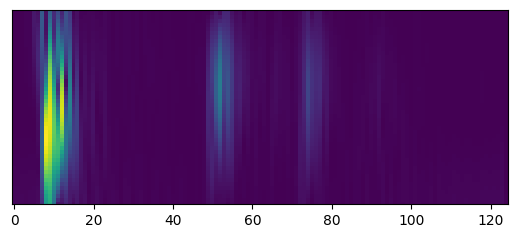

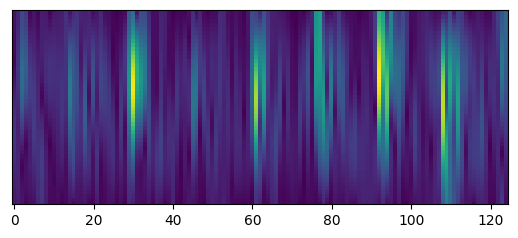

In [31]:
# get train_data and noise_data
t1_list = [470,110,180,555,10]
t2_list = [490,130,200,575,20]
subway_stone_data1 = select_part_spec(t1_list[0],t2_list[0],stone_data)
subway_stone_data2 = select_part_spec(t1_list[1],t2_list[1],stone_data)
subway_jump_data1 = select_part_spec(t1_list[2],t2_list[2],train_jump_data) 
subway_jump_data2 = select_part_spec(t1_list[3],t2_list[3],train_jump_data) 
noise_from_stone_data = select_part_spec(t1_list[4],t2_list[4],stone_data)
noise_from_jump_data = select_part_spec(t1_list[4],t2_list[4],train_jump_data)

# get part of stone data
dt = 500
t1 = int(596.75*dt)
t2 = int(597.75*dt)
stone_fall_data = stone_data[t1:t2,:,:].copy()
stone_fall_data = norm(stone_fall_data).transpose(1,2,0)
stone_fall_data = cal_norm_spectrogram(stone_fall_data,8,100,500)

# get part of fall data
t1 = 703
t2 = 704
jump_data = select_part_spec(t1,t2,train_jump_data) 

# it is easy to see the difference between the spectrum of two data
plot_spec(stone_fall_data,0)
plot_spec(subway_jump_data1,0)

## 4. Extract and visualize features

#### <blockquote> Here, we use a pre-trained encoder to extract features from various waveforms, including 1-second-long train events, rockfall events, human activities, and noise.

In [32]:
freeze_model.eval()
concat_data = np.concatenate([jump_data,stone_fall_data,subway_stone_data1,subway_stone_data2,subway_jump_data1,subway_jump_data2,noise_from_stone_data,noise_from_jump_data],axis = 0)
# we only use [120,50] size of the data
concat_data_torch = torch.tensor(concat_data[:,:,0:120,:]).to(device)
# using model.encode_audio to extract the feature of total data
temp_output = freeze_model.encode_audio(concat_data_torch)
print(concat_data_torch.shape)
print(temp_output.shape)

torch.Size([204, 3, 120, 50])
torch.Size([204, 384])


#### <blockquote> Finally, use PCA to ruduce 384D features to 2D for visualizing it. If you don't need to reduce the features, you would use the extract for any task in seismology field. The details about use it for classification can be found in 'Classification Section' of our code.

(204, 2)


/var/folders/0j/ghv94v0d5rjg_y_rsjwtjkpc0000gn/T/ipykernel_34658/822569826.py:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


([], [])

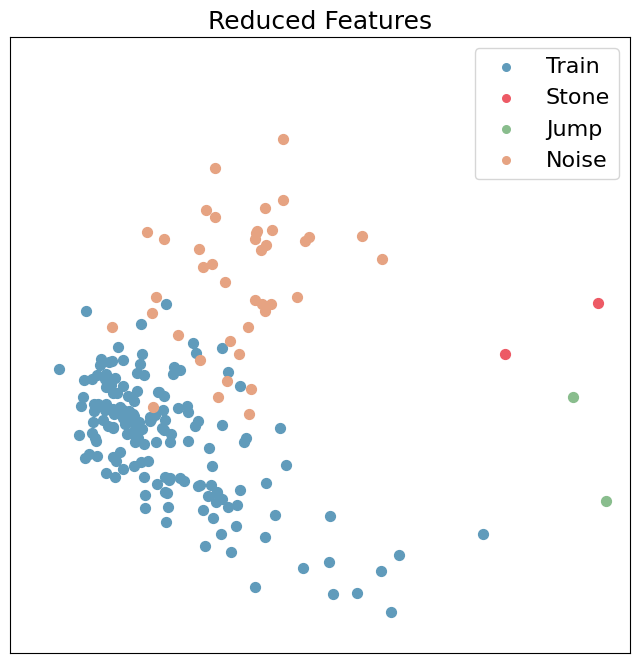

In [38]:
# define label for plot
label = np.zeros(204,dtype='int')

label[0:2] = 1
label[2:4] = 2
label[164:204] = 3

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(temp_output.detach().cpu().numpy())  # (batch_size, 2)
#reduced_features from [204,384] --> [204,2]

labels = label.copy()
# define colorbar
unique_labels = np.unique(labels)
colors = ['#609bbb', '#ed5a65', '#89bd8d', '#e6a382']  # define colorbar 
label_list = ['Train','Stone','Jump','Noise']
label_color_map = {label: color for label, color in zip(unique_labels, colors)}

plt.figure(figsize = (8,8), dpi = 100)
# 绘制散点图
for label in unique_labels:
    indices = np.where(labels == label)
    plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], c=label_color_map[label],label=label_list[label],s = 50)

legend = plt.legend(loc = 0,prop={'size': 16})
for handle in legend.legendHandles:
    handle.set_sizes([30])  # set dots size in the legend
    
plt.xlim(-8,20)
plt.ylim(-10,15)
plt.title('Reduced Features',fontsize = 18)

plt.xticks([])
plt.yticks([])

# plt.show()